# Regridding the MLD climatology from de Boyer Montégut onto the ASTE grid

In [1]:
import xarray as xr
import xmitgcm
import MITgcm_recipes
import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Get the datasets

### MLD climatology

In [2]:
mld_dir = '/local/data/artemis/workspace/rdussin/Observations/MLD_deBoyerMontegut/originals/'
mld_rho_ds = xr.open_dataset(mld_dir + 'mld_DR003_c1m_reg2.0.nc')

mld fields have different special values for land and missing data:

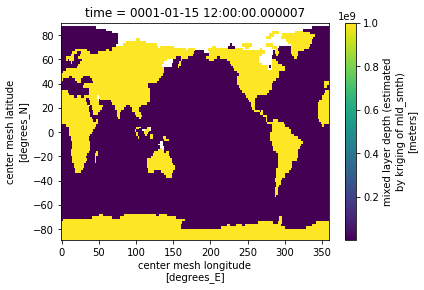

In [3]:
mld_rho_ds['mld'].isel(time=0).plot()

We need to change that to:

In [4]:
mld_rho_ds = mld_rho_ds.where(mld_rho_ds['mld'] != 1.0e9)

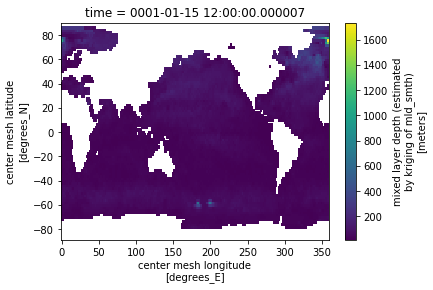

In [5]:
mld_rho_ds['mld'].isel(time=0).plot()

We also need to move the mld to -180/180

In [6]:
def geo_roll_360_to_180(ds, londim):
    ind = (np.abs(ds[londim]-180.)).argmin().values
    ds = ds.roll(**{londim: -ind})
    datalon=ds[londim].values
    datalon[:ind] -=360
    ds[londim] = datalon
    return ds

In [7]:
mld_rho_ds360 = geo_roll_360_to_180(mld_rho_ds, 'lon')

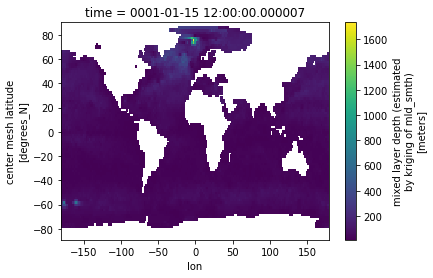

In [8]:
mld_rho_ds360['mld'].isel(time=0).plot()

### ASTE raw grid

In [9]:
file_aste_raw = '/local/data/artemis/workspace/rdussin/ASTE/GRID/nc/aste_grid.nc'
aste_raw = xr.open_dataset(file_aste_raw)

## Regridding

The mld fields are not gonna be used to force the model so no extrapolation is needed.
Those are 2d fields so no vertical interpolation either

In [10]:
mld_aste = MITgcm_recipes.regridding.regrid_2_mitgcm_llc(mld_rho_ds360, aste_raw, ['mld'], 
                                                         method='bilinear',
                                                         lonname='lon', latname='lat', point='T', 
                                                         periodic=True, reuse_weights=False)

Overwrite existing file: regrid_face0.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face1.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face2.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face3.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face4.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: regrid_face5.nc 
 You can set reuse_weights=True to save computing time.


## Checking the results

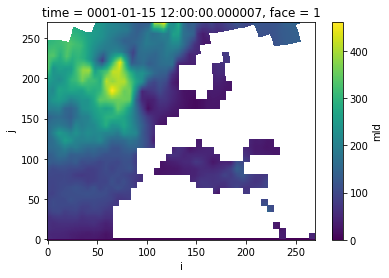

In [11]:
mld_aste.mld.isel(face=1, time=0).plot()

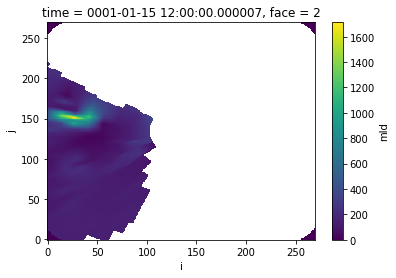

In [12]:
mld_aste.mld.isel(face=2, time=0).plot()

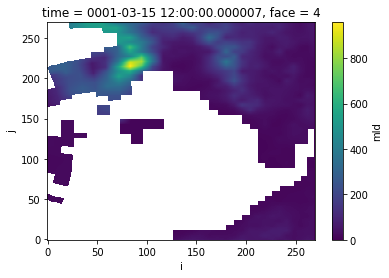

In [13]:
mld_aste.mld.isel(face=4, time=2).plot()

## Write to netcdf file

In [14]:
mld_aste['time'] = xr.DataArray(np.arange(12), dims=['time'], attrs={'units':'months since 1900-01-15 0:00:00'})
mld_aste = mld_aste.transpose(*('time','face','j','i'))
mld_aste.to_netcdf(mld_dir + '../interp_ASTE/' + 'clim_mld_Rho003_dbmontegut_ASTE.nc', unlimited_dims='time')

### Checkfile

In [15]:
test = xr.open_dataset(mld_dir + '../interp_ASTE/' + 'clim_mld_Rho003_dbmontegut_ASTE.nc', decode_times=False)

In [16]:
test

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, j: 270, time: 12)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * face     (face) int64 0 1 2 3 4 5
Data variables:
    mld      (time, face, j, i) float64 ...